### This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average process of income/earnings
 - It allows for different assumptions about expectations, ranging from rational expectation to alternative assumptions. 

In [115]:
import numpy as np
import matplotlib.pyplot as plt

In [210]:
## class of integrated moving average process, trend/cycle process allowing for serial correlation transitory shocks
class IMAProcess:
    '''
    inputs
    ------
    t: int, number of periods of the series
    process_para, dictionary, includes 
       - ma_coeffs: size f q for MA(q),  moving average coeffcients of transitory shocks. q = 0 by default.
       - sigmas:  size of t x 2, draws of permanent and transitory risks from time varying volatility 
    '''
    def __init__(self,
                 t = 100,
                 process_para = {'ma_coeffs':np.ones(0),
                                 'sigmas': np.ones((2,100))}
                ):
        self.ma_coeffs = process_para['ma_coeffs']
        self.ma_q = len(process_para)
        self.t = t
        self.sigmas = process_para['sigmas']
    
    ## auxiliary function for ma cum sum
    def cumshocks(self,
                  shocks,
                  ma_coeffs):
        cum = []
        for i in range(len(shocks)):
            cum.append(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
        return np.array(cum)         
    
    def SimulateSeries(self,
                      n_sim = 100):
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        ma_q = self.ma_q 
                 
        p_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  # draw permanent shocks
        t_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  ## draw one-period transitory shocks 
        t_draws_cum = np.array( [self.cumshocks(shocks = t_draws[i,:],
                                                ma_coeffs = ma_coeffs) 
                                 for i in range(n_sim)]
                              )
        series = np.cumsum(p_draws,axis = 1) + t_draws_cum 
        self.simulated = series
        return self.simulated 
       
    def SimulatedMoments(self):
        series = self.simulated 
        
        ## the first difference 
        diff = np.diff(series,axis=1)
        
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.SimMoms

In [268]:
## debugging test of the data 

t = 200
ma_nosa = np.zeros(0)
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
pt_ratio = 1
t_sigmas = pt_ratio *p_sigmas # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_rw,
                   t_sigmas])

dt = IMAProcess(t = t,
               process_para = {'ma_coeffs':ma_nosa,
                              'sigmas':sigmas})
sim_data = dt.SimulateSeries(n_sim =100000)
sim_moms = dt.SimulatedMoments()

In [269]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
autovarb1 = np.array([cov_var[i,i-1] for i in range(len(cov_var))]) 
autovarf1 = np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

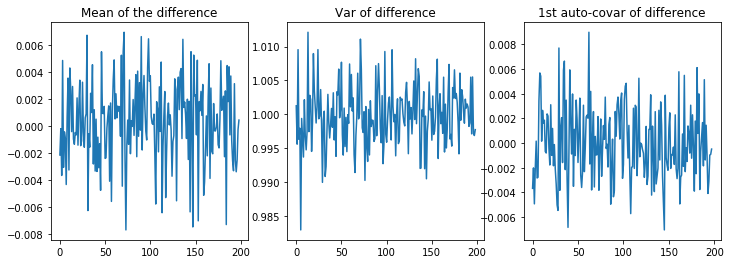

In [270]:
## plot simulated moments of first diff 

plt.figure(figsize=((12,4)))
plt.subplot(1,3,1)
plt.title('Mean of the difference')
plt.plot(av)

plt.subplot(1,3,2)
plt.title('Var of difference')
var = np.diagonal(cov_var)
plt.plot(var)

plt.subplot(1,3,3)
plt.title('1st auto-covar of difference')
plt.plot(autovarf1)